# HEOM 5b: Discrete boson coupled to an impurity and fermionic leads

## Introduction

Here we model a single fermion coupled to two electronic leads or reservoirs (e.g.,  this can describe a single quantum dot, a molecular transistor, etc), also coupled to a discrete bosonic (vibronic) mode.

Note that in this implementation we primarily follow the definitions used by Christian Schinabeck in his Dissertation https://open.fau.de/items/36fdd708-a467-4b59-bf4e-4a2110fbc431 and related publications. In particular this example reproduces some results from https://journals.aps.org/prb/abstract/10.1103/PhysRevB.94.201407

Notation:

* $K=L/R$ refers to  left or right leads.
* $\sigma=\pm$ refers to input/output

We choose a Lorentzian spectral density for the leads, with a peak at the chemical potential. The latter simplifies a little the notation required for the correlation functions, but can be relaxed if neccessary.

$$J(\omega) = \frac{\Gamma  W^2}{((\omega-\mu_K)^2 +W^2 )}$$

The Fermi distribution function is:

$$f_F (x) = (\exp(x) + 1)^{-1}$$

Together these allow the correlation functions to be expressed as:

$$C^{\sigma}_K(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} d\omega e^{\sigma i \omega t} \Gamma_K(\omega) f_F[\sigma\beta(\omega - \mu)]$$

As with the Bosonic case we can treat these with Matsubara, Pade, or fitting approaches.

The Pade decomposition approximates the Fermi distubition as 

$$f_F(x) \approx f_F^{\mathrm{approx}}(x) = \frac{1}{2} - \sum_l^{l_{max}} \frac{2k_l x}{x^2 + \epsilon_l^2}$$

$k_l$ and $\epsilon_l$ are co-efficients defined in J. Chem Phys 133,10106

Evaluating the integral for the correlation functions gives,


$$C_K^{\sigma}(t) \approx \sum_{l=0}^{l_{max}} \eta_K^{\sigma_l} e^{-\gamma_{K,\sigma,l}t}$$

where

$$\eta_{K,0} = \frac{\Gamma_KW_K}{2} f_F^{approx}(i\beta_K W)$$

$$\gamma_{K,\sigma,0} = W_K - \sigma i\mu_K$$ 

$$\eta_{K,l\neq 0} = -i\cdot \frac{k_m}{\beta_K} \cdot \frac{\Gamma_K W_K^2}{-\frac{\epsilon^2_m}{\beta_K^2} + W_K^2}$$

$$\gamma_{K,\sigma,l\neq 0}= \frac{\epsilon_m}{\beta_K} - \sigma i \mu_K$$

## Differences from Example 5a

The system we study here has two big differences from the HEOM 5a example:

* the system now includes a discrete bosonic mode,
* and the electronic leads have $W$ set to $10^4$ (i.e. the wide-band limit).

The new system Hamiltonian is:

$$
H_{\mathrm{vib}} = H_{\mathrm{SIAM}} + \Omega a^{\dagger}a + \lambda (a+a^{\dagger})c{^\dagger}c.
$$

where $H_{\mathrm{SIAM}}$ is the Hamiltonian of the single impurity, and the remaining terms are the Hamiltonian of the bosonic mode and its interaction with the impurity.

The complete setup now consists of four parts:

* the single impurity
* a discrete bosonic mode
* two fermionic leads.

**Note**: This example is quite numerically challenging and has many system and bath components. For an easier introduction into the fermionic case, see example 5a.

**Note**: We've reduced the cut-off of the bosonic mode to 2 modes to facilitate faster execution of the notebooks when the outputs are being checked and compiled. A more accurate result may be obtained by increasing the number of bosonic modes to, for example, 16.

## Setup

In [1]:
import contextlib
import dataclasses
import time

import matplotlib.pyplot as plt
import numpy as np

import qutip
from qutip import (
    Options,
    destroy,
    qeye,
    tensor,
)
from qutip.nonmarkov.heom import (
    HEOMSolver,
    LorentzianPadeBath,
)

from ipywidgets import IntProgress
from IPython.display import display

%matplotlib inline

## Helpers

In [2]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [3]:
def state_current(ado_state, bath_tag):
    """ Determine current from the given bath (either "R" or "L") to
        the system in the given ADO state.
    """
    level_1_aux = [
        (ado_state.extract(label), ado_state.exps(label)[0])
        for label in ado_state.filter(level=1, tags=[bath_tag])
    ]

    def exp_sign(exp):
        return 1 if exp.type == exp.types["+"] else -1

    def exp_op(exp):
        return exp.Q if exp.type == exp.types["+"] else exp.Q.dag()

    return -1.0j * sum(
        exp_sign(exp) * (exp_op(exp) * aux).tr()
        for aux, exp in level_1_aux
    )

## System and bath definition

Let us set up the system Hamiltonian and specify the properties of the two reservoirs.

In [4]:
# Define the system Hamiltonian:

@dataclasses.dataclass
class SystemParameters:
    e1: float = 0.3  # fermion mode energy splitting
    Omega: float = 0.2  # bosonic mode energy splitting
    Lambda: float = 0.12  # coupling between fermion and boson
    Nbos: int = 2

    def __post_init__(self):
        d = tensor(destroy(2), qeye(self.Nbos))
        a = tensor(qeye(2), destroy(self.Nbos))
        self.H = (
            self.e1 * d.dag() * d +
            self.Omega * a.dag() * a +
            self.Lambda * (a + a.dag()) * d.dag() * d
        )
        self.Q = d

    def replace(self, **kw):
        return dataclasses.replace(self, **kw)


sys_p = SystemParameters()

In [5]:
# Define parameters for left and right fermionic baths.
# Each bath is a lead (i.e. a wire held at a potential)
# with temperature T and chemical potential mu.

@dataclasses.dataclass
class LorentzianBathParameters:
    lead: str
    gamma: float = 0.01  # coupling strength
    W: float = 1.0  # cut-off
    T: float = 0.025851991  # temperature (in eV)
    theta: float = 2.0  # bias

    def __post_init__(self):
        assert self.lead in ("L", "R")
        self.beta = 1 / self.T
        if self.lead == "L":
            self.mu = self.theta / 2.0
        else:
            self.mu = - self.theta / 2.0

    def J(self, w):
        """ Spectral density. """
        return self.gamma * self.W**2 / ((w - self.mu)**2 + self.W**2)

    def fF(self, w, sign=1.0):
        """ Fermi distribution for this bath. """
        x = sign * self.beta * (w - self.mu)
        return fF(x)

    def lamshift(self, w):
        """ Return the lamshift. """
        return 0.5 * (w - self.mu) * self.J(w) / self.W

    def replace(self, **kw):
        return dataclasses.replace(self, **kw)


def fF(x):
    """ Return the Fermi distribution. """
    # in units where kB = 1.0
    return 1 / (np.exp(x) + 1)


# We set W = 1e4 to investigate the wide-band limit:

bath_L = LorentzianBathParameters(W=10**4, lead="L")
bath_R = LorentzianBathParameters(W=10**4, lead="R")

## Emission and absorption by the leads

Next let's plot the emission and absorption by the leads.

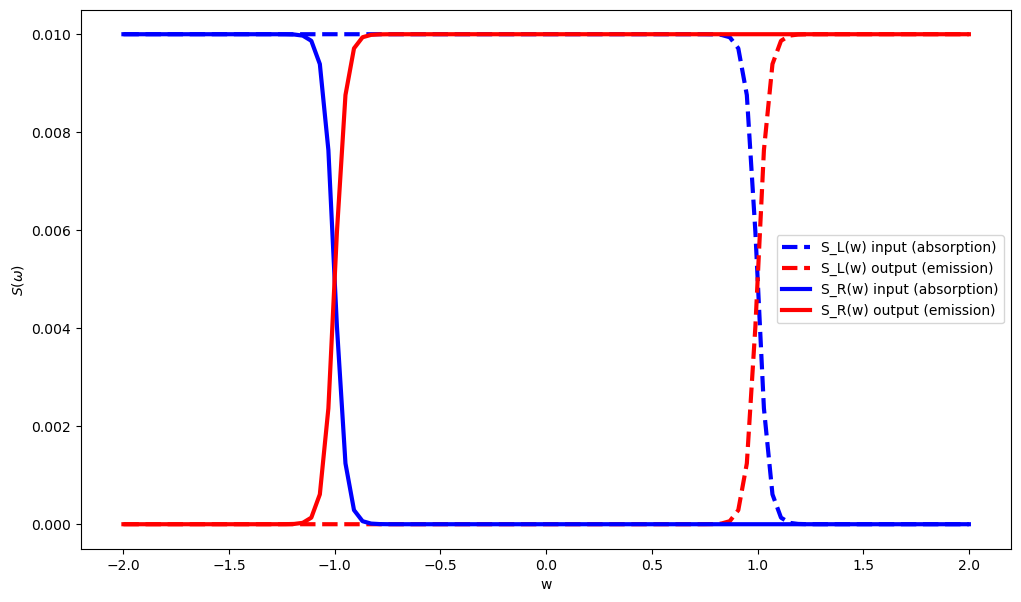

In [6]:
w_list = np.linspace(-2, 2, 100)

fig, ax = plt.subplots(figsize=(12, 7))

# Left lead emission and absorption

gam_L_in = bath_L.J(w_list) * bath_L.fF(w_list, sign=1.0)
gam_L_out = bath_L.J(w_list) * bath_L.fF(w_list, sign=-1.0)

ax.plot(
    w_list, gam_L_in,
    "b--", linewidth=3,
    label=r"S_L(w) input (absorption)",
)
ax.plot(
    w_list, gam_L_out,
    "r--", linewidth=3,
    label=r"S_L(w) output (emission)",
)

# Right lead emission and absorption

gam_R_in = bath_R.J(w_list) * bath_R.fF(w_list, sign=1.0)
gam_R_out = bath_R.J(w_list) * bath_R.fF(w_list, sign=-1.0)

ax.plot(
    w_list, gam_R_in,
    "b", linewidth=3,
    label=r"S_R(w) input (absorption)",
)
ax.plot(
    w_list, gam_R_out,
    "r", linewidth=3,
    label=r"S_R(w) output (emission)",
)

ax.set_xlabel("w")
ax.set_ylabel(r"$S(\omega)$")
ax.legend();

## Below we give one example data set from Paper

Here we just give one example of the current as a function of bias voltage, but in general one can try different cut-offs of the bosonic Fock space and the expansion of the correlation functions until convergence is found.

One note:  for very large problems, this can be slow.

In [7]:
def steady_state_pade_for_theta(sys_p, bath_L, bath_R, theta, Nk, Nc, Nbos):
    """ Return the steady state current using the Pade approximation. """
    options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

    sys_p = sys_p.replace(Nbos=Nbos)
    bath_L = bath_L.replace(theta=theta)
    bath_R = bath_R.replace(theta=theta)

    bathL = LorentzianPadeBath(
        sys_p.Q, bath_L.gamma, bath_L.W, bath_L.mu, bath_L.T,
        Nk, tag="L",
    )
    bathR = LorentzianPadeBath(
        sys_p.Q, bath_R.gamma, bath_R.W, bath_R.mu, bath_R.T,
        Nk, tag="R",
    )

    solver_pade = HEOMSolver(
        sys_p.H, [bathL, bathR], max_depth=2, options=options,
    )
    rho_ss_pade, ado_ss_pade = solver_pade.steady_state()
    current = state_current(ado_ss_pade, bath_tag="R")

    return np.real(2.434e-4 * 1e6 * current)

In [8]:
# Parameters:

Nk = 6
Nc = 2
Nbos = 2  # Use Nbos = 16 for more accurate results

thetas = np.linspace(0, 2, 30)

# Progress bar:

progress = IntProgress(min=0, max=len(thetas))
display(progress)

currents = []

for theta in thetas:
    currents.append(steady_state_pade_for_theta(
        sys_p, bath_L, bath_R, theta,
        Nk=Nk, Nc=Nc, Nbos=Nbos,
    ))
    progress.value += 1

IntProgress(value=0, max=30)

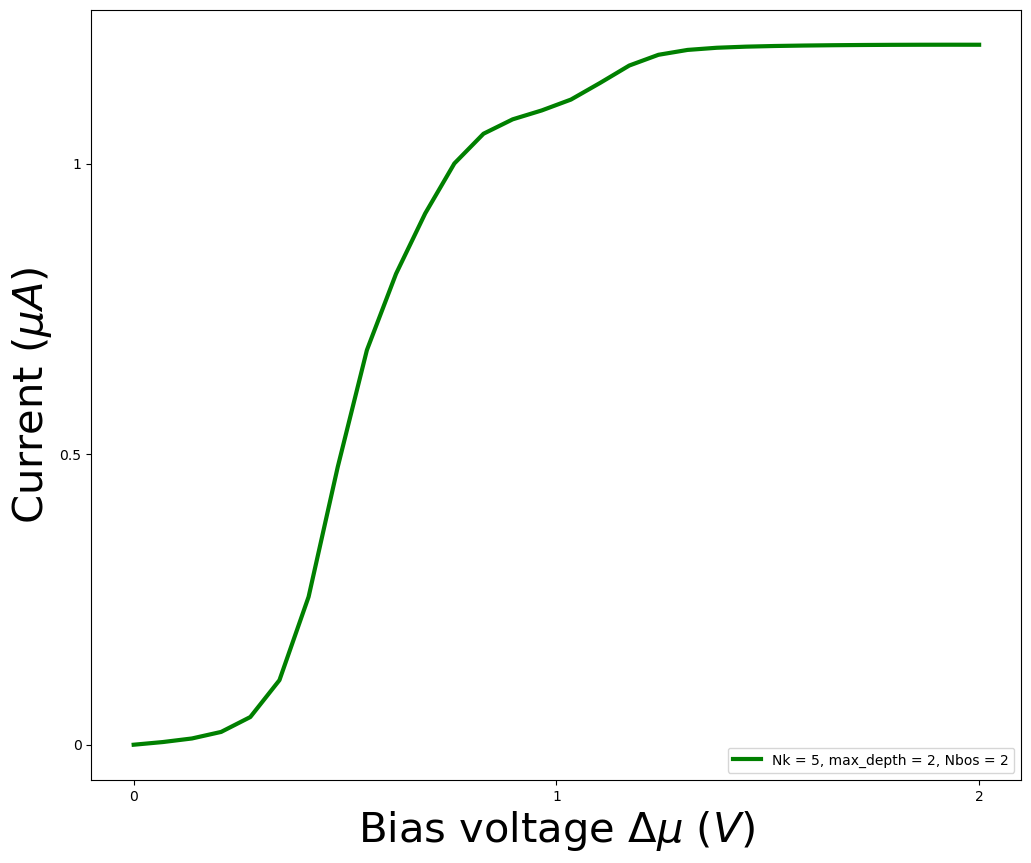

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(
    thetas, currents,
    color="green", linestyle='-', linewidth=3,
    label=f"Nk = {5}, max_depth = {Nc}, Nbos = {Nbos}",
)

ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0, 0.5, 1])

ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=4)

ax.set_xlabel(r"Bias voltage $\Delta \mu$ ($V$)", fontsize=30)
ax.set_ylabel(r"Current ($\mu A$)", fontsize=30)
ax.legend(loc=4);

## About

In [10]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.6
Numpy Version:      1.26.4
Scipy Version:      1.12.0
Cython Version:     0.29.37
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     4
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v4/lib/python3.10/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex refer

## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [11]:
assert 1 == 1